# 준비

## Install packages

In [ ]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

import time

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/빅콘테스트/일반화"

/content/drive/.shortcut-targets-by-id/1GCTEcT0q5lWe-tMaCZxefSgTTohr25-M/빅콘테스트/일반화


In [ ]:
# zip 파일 풀기
!unzip -qq "/content/drive/MyDrive/빅콘테스트/일반화/archive (1).zip"

unzip:  cannot find or open /content/drive/MyDrive/빅콘테스트/일반화/archive (1).zip, /content/drive/MyDrive/빅콘테스트/일반화/archive (1).zip.zip or /content/drive/MyDrive/빅콘테스트/일반화/archive (1).zip.ZIP.


In [ ]:
data_dir  = '/content/drive/MyDrive/Colab Notebooks/빅콘테스트/일반화/Garbage classification/Garbage classification'

classes = os.listdir(data_dir)
print(classes)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

## 데이터 전처리

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: cardboard (Class No: 0)


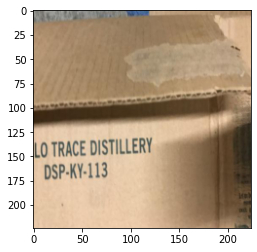

In [ ]:
img, label = dataset[12]
show_sample(img, label)

In [ ]:
random_seed = 2021
torch.manual_seed(random_seed)

## Train/Test Split

In [ ]:
train_ds, val_ds, test_ds = random_split(dataset, [1617, 404, 506]) # 총 2527개의 이미지 # 80%, 20%
len(train_ds), len(val_ds), len(test_ds)

(1617, 404, 506)

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 2, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers = 2, pin_memory = True)

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

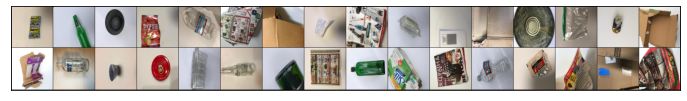

In [ ]:
show_batch(train_dl)

# Modeling

## 모델 구체화

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}, time : {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc'], result['time']))

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# Function to test what classes performed well
def testClassess(model):
    class_correct = list(0. for i in range(6))
    class_total = list(0. for i in range(6))
    with torch.no_grad():
        for data in test_dl:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(batch_size):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    for i in range(6):
        print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
from torch.autograd import Variable

# Function to save the model
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy(model):
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_dl:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)

### history()

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        start_time = time.time()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['time']=(time.time()-start_time)/60
        model.epoch_end(epoch, result)
        history.append(result)

    # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
    accuracy = testAccuracy(model)
    print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
    testClassess(model)
    
    return history


In [ ]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 5.5e-5

## ResNet 18 (논문 구현)
- 224,224  --> conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False) , MaxPool2d(kernel_size=3, stride=2, padding=1)

In [ ]:
# ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(ImageClassificationBase):
    def __init__(self, block, num_blocks, num_classes=6):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet18 함수 정의
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

model_res18_non= ResNet18()

In [ ]:
to_device(model_res18_non, device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), p

In [ ]:
model_res18_non= to_device(ResNet18(), device)

In [ ]:
history_res18_non = fit(num_epochs, lr, model_res18_non, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 0.0316, val_loss: 1.4371, val_acc: 0.6772, time : 0.2643
Epoch 2: train_loss: 0.0158, val_loss: 1.1932, val_acc: 0.7558, time : 0.2706
Epoch 3: train_loss: 0.0205, val_loss: 1.8401, val_acc: 0.5866, time : 0.2702
Epoch 4: train_loss: 0.0335, val_loss: 1.5936, val_acc: 0.6473, time : 0.2748
Epoch 5: train_loss: 0.0723, val_loss: 2.5342, val_acc: 0.6054, time : 0.2732
Epoch 6: train_loss: 0.0882, val_loss: 1.3771, val_acc: 0.6527, time : 0.2727
Epoch 7: train_loss: 0.0372, val_loss: 1.2416, val_acc: 0.7018, time : 0.2719
Epoch 8: train_loss: 0.0116, val_loss: 1.2244, val_acc: 0.6942, time : 0.2555
Epoch 9: train_loss: 0.0057, val_loss: 1.1798, val_acc: 0.7237, time : 0.2683
Epoch 10: train_loss: 0.0037, val_loss: 1.1486, val_acc: 0.7393, time : 0.2721
Epoch 11: train_loss: 0.0028, val_loss: 1.1490, val_acc: 0.7326, time : 0.2685
Epoch 12: train_loss: 0.0027, val_loss: 1.1414, val_acc: 0.7393, time : 0.2705
Epoch 13: train_loss: 0.0027, val_loss: 1.1647, val_acc: 0.74

## 사전학습모델

## ResNet 18

In [ ]:
class ResNet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model_res18 = ResNet18()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
to_device(model_res18, device)

ResNet18(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
model_res18= to_device(ResNet18(), device)

In [ ]:
history_res18 = fit(num_epochs, lr, model_res18, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.4986, val_loss: 1.3302, val_acc: 0.8179, time : 0.2550
Epoch 2: train_loss: 1.2648, val_loss: 1.2327, val_acc: 0.8781, time : 0.2583
Epoch 3: train_loss: 1.1704, val_loss: 1.1840, val_acc: 0.8915, time : 0.2613
Epoch 4: train_loss: 1.1120, val_loss: 1.1631, val_acc: 0.9187, time : 0.2594
Epoch 5: train_loss: 1.0851, val_loss: 1.1507, val_acc: 0.9187, time : 0.2534
Epoch 6: train_loss: 1.0698, val_loss: 1.1480, val_acc: 0.9098, time : 0.2643
Epoch 7: train_loss: 1.0634, val_loss: 1.1417, val_acc: 0.9187, time : 0.2533
Epoch 8: train_loss: 1.0589, val_loss: 1.1393, val_acc: 0.9210, time : 0.2553
Epoch 9: train_loss: 1.0541, val_loss: 1.1367, val_acc: 0.9210, time : 0.2606
Epoch 10: train_loss: 1.0539, val_loss: 1.1333, val_acc: 0.9165, time : 0.2560
Epoch 11: train_loss: 1.0545, val_loss: 1.1380, val_acc: 0.9161, time : 0.2555
Epoch 12: train_loss: 1.0517, val_loss: 1.1291, val_acc: 0.9299, time : 0.2568
Epoch 13: train_loss: 1.0502, val_loss: 1.1282, val_acc: 0.92

## ResNet 34

In [ ]:
class ResNet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model_res34 = ResNet34()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
to_device(model_res34, device)

ResNet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
model_res34= to_device(ResNet34(), device)

In [ ]:
history_res34 = fit(num_epochs, lr, model_res34, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.4733, val_loss: 1.2794, val_acc: 0.8647, time : 0.3846
Epoch 2: train_loss: 1.2138, val_loss: 1.1788, val_acc: 0.9116, time : 0.3851
Epoch 3: train_loss: 1.1190, val_loss: 1.1460, val_acc: 0.9344, time : 0.3812
Epoch 4: train_loss: 1.0844, val_loss: 1.1296, val_acc: 0.9348, time : 0.3811
Epoch 5: train_loss: 1.0682, val_loss: 1.1256, val_acc: 0.9250, time : 0.3824
Epoch 6: train_loss: 1.0598, val_loss: 1.1263, val_acc: 0.9295, time : 0.3809
Epoch 7: train_loss: 1.0578, val_loss: 1.1201, val_acc: 0.9397, time : 0.3811
Epoch 8: train_loss: 1.0547, val_loss: 1.1219, val_acc: 0.9304, time : 0.3825
Epoch 9: train_loss: 1.0541, val_loss: 1.1124, val_acc: 0.9366, time : 0.3825
Epoch 10: train_loss: 1.0550, val_loss: 1.1164, val_acc: 0.9348, time : 0.3807
Epoch 11: train_loss: 1.0579, val_loss: 1.1365, val_acc: 0.9103, time : 0.3830
Epoch 12: train_loss: 1.0526, val_loss: 1.1277, val_acc: 0.9143, time : 0.3794
Epoch 13: train_loss: 1.0534, val_loss: 1.1284, val_acc: 0.92

## ResNet 50

In [ ]:
class ResNet50(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model_res50 = ResNet50()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
to_device(model_res50, device)

ResNet50(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

In [ ]:
model_res50= to_device(ResNet50(), device)

In [ ]:
history_res50= fit(num_epochs, lr, model_res50, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.4675, val_loss: 1.2462, val_acc: 0.8670, time : 0.6828
Epoch 2: train_loss: 1.1736, val_loss: 1.1689, val_acc: 0.9031, time : 0.6763
Epoch 3: train_loss: 1.0944, val_loss: 1.1267, val_acc: 0.9437, time : 0.6732
Epoch 4: train_loss: 1.0670, val_loss: 1.1153, val_acc: 0.9437, time : 0.6783
Epoch 5: train_loss: 1.0594, val_loss: 1.1114, val_acc: 0.9504, time : 0.6747
Epoch 6: train_loss: 1.0560, val_loss: 1.1127, val_acc: 0.9388, time : 0.6753
Epoch 7: train_loss: 1.0518, val_loss: 1.1099, val_acc: 0.9411, time : 0.6777
Epoch 8: train_loss: 1.0513, val_loss: 1.1073, val_acc: 0.9527, time : 0.6783
Epoch 9: train_loss: 1.0509, val_loss: 1.1167, val_acc: 0.9371, time : 0.6763
Epoch 10: train_loss: 1.0524, val_loss: 1.1090, val_acc: 0.9393, time : 0.6789
Epoch 11: train_loss: 1.0555, val_loss: 1.1193, val_acc: 0.9348, time : 0.6801
Epoch 12: train_loss: 1.0612, val_loss: 1.1144, val_acc: 0.9348, time : 0.6812
Epoch 13: train_loss: 1.0615, val_loss: 1.1208, val_acc: 0.92

## ResNet101

In [ ]:
class ResNet101(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet101(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model_res101 = ResNet101()

In [ ]:
to_device(model_res101, device)

ResNet101(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [ ]:
model_res101= to_device(ResNet101(), device)

In [ ]:
history_res101= fit(num_epochs, lr, model_res101, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.4462, val_loss: 1.1961, val_acc: 0.8737, time : 1.1097
Epoch 2: train_loss: 1.1503, val_loss: 1.1351, val_acc: 0.9214, time : 1.1056
Epoch 3: train_loss: 1.0873, val_loss: 1.1225, val_acc: 0.9277, time : 1.1046
Epoch 4: train_loss: 1.0694, val_loss: 1.1104, val_acc: 0.9437, time : 1.1068
Epoch 5: train_loss: 1.0665, val_loss: 1.1164, val_acc: 0.9205, time : 1.1040
Epoch 6: train_loss: 1.0593, val_loss: 1.1181, val_acc: 0.9232, time : 1.1034
Epoch 7: train_loss: 1.0566, val_loss: 1.1087, val_acc: 0.9366, time : 1.1038
Epoch 8: train_loss: 1.0596, val_loss: 1.1132, val_acc: 0.9321, time : 1.1028
Epoch 9: train_loss: 1.0567, val_loss: 1.1190, val_acc: 0.9165, time : 1.1027
Epoch 10: train_loss: 1.0645, val_loss: 1.1167, val_acc: 0.9272, time : 1.1049
Epoch 11: train_loss: 1.0551, val_loss: 1.1082, val_acc: 0.9388, time : 1.1037
Epoch 12: train_loss: 1.0536, val_loss: 1.1177, val_acc: 0.9161, time : 1.1032
Epoch 13: train_loss: 1.0513, val_loss: 1.1246, val_acc: 0.91

## ResNet 152

In [ ]:
class ResNet152(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet152(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model_res152 = ResNet152()

In [ ]:
to_device(model_res152, device)

ResNet152(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [ ]:
model_res152 = to_device(ResNet152(), device)

In [ ]:
evaluate(model_res152, val_dl)

{'val_acc': 0.22232142090797424, 'val_loss': 1.794773817062378}

In [ ]:
history_res152 = fit(num_epochs, lr, model_res152, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.4487, val_loss: 1.2085, val_acc: 0.8804, time : 1.5605
Epoch 2: train_loss: 1.1446, val_loss: 1.1471, val_acc: 0.9098, time : 1.5522
Epoch 3: train_loss: 1.0820, val_loss: 1.1441, val_acc: 0.9125, time : 1.5529
Epoch 4: train_loss: 1.0664, val_loss: 1.1135, val_acc: 0.9348, time : 1.5536
Epoch 5: train_loss: 1.0622, val_loss: 1.1295, val_acc: 0.9143, time : 1.5540
Epoch 6: train_loss: 1.0619, val_loss: 1.1156, val_acc: 0.9299, time : 1.5532
Epoch 7: train_loss: 1.0641, val_loss: 1.1242, val_acc: 0.9067, time : 1.5520
Epoch 8: train_loss: 1.0631, val_loss: 1.1296, val_acc: 0.9192, time : 1.5529
Epoch 9: train_loss: 1.0658, val_loss: 1.1190, val_acc: 0.9259, time : 1.5523
Epoch 10: train_loss: 1.0548, val_loss: 1.1056, val_acc: 0.9388, time : 1.5515
Epoch 11: train_loss: 1.0529, val_loss: 1.1019, val_acc: 0.9388, time : 1.5533
Epoch 12: train_loss: 1.0509, val_loss: 1.1094, val_acc: 0.9348, time : 1.5524
Epoch 13: train_loss: 1.0536, val_loss: 1.1039, val_acc: 0.93

# 결과


## 성능 그래프

### accuracy

In [ ]:
import numpy as np
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xticks(np.arange(1, 8, 1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('epoch')
    plt.ylabel('accuracy');

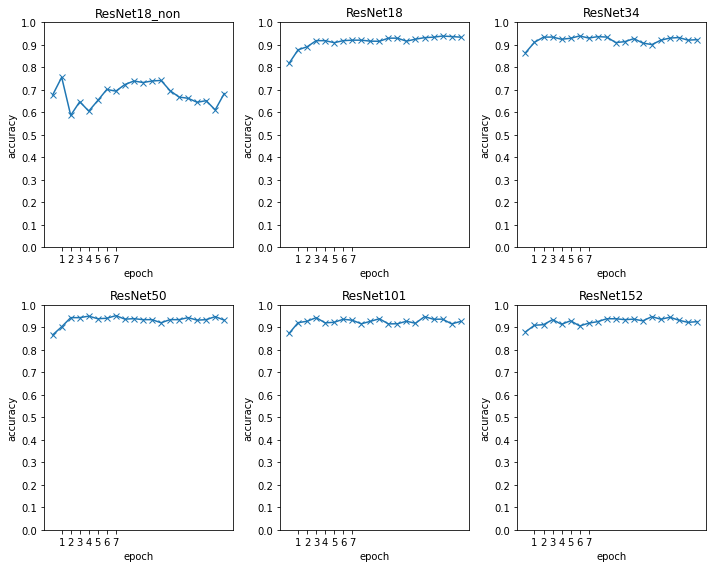

In [ ]:
plt.figure(figsize = (10,8))
plt.subplot(231)
plot_accuracies(history_res18_non)
plt.title('ResNet18_non')
plt.subplot(232)
plot_accuracies(history_res18)
plt.title('ResNet18')
plt.subplot(233)
plot_accuracies(history_res34)
plt.title('ResNet34')
plt.subplot(234)
plot_accuracies(history_res50)
plt.title('ResNet50')
plt.subplot(235)
plot_accuracies(history_res101)
plt.title('ResNet101')
plt.subplot(236)
plot_accuracies(history_res152)
plt.title('ResNet152')
plt.tight_layout()

### loss

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation']);

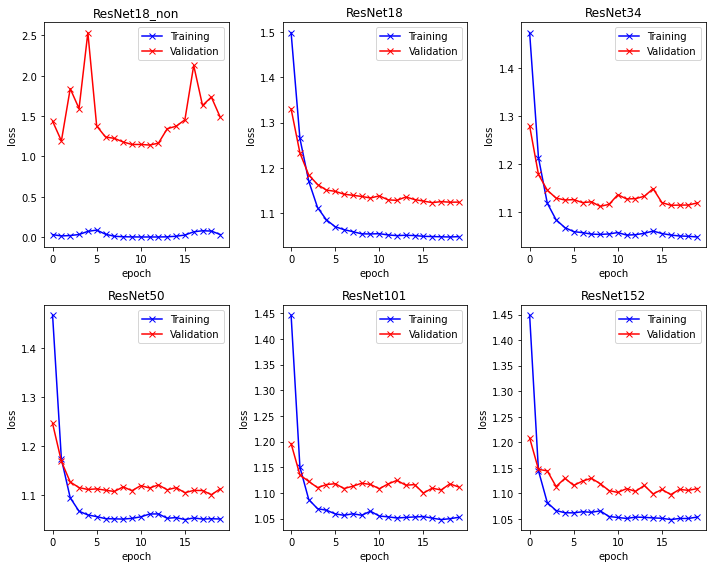

In [ ]:
plt.figure(figsize = (10,8))
plt.subplot(231)
plot_losses(history_res18_non)
plt.title('ResNet18_non')
plt.subplot(232)
plot_losses(history_res18)
plt.title('ResNet18')
plt.subplot(233)
plot_losses(history_res34)
plt.title('ResNet34')
plt.subplot(234)
plot_losses(history_res50)
plt.title('ResNet50')
plt.subplot(235)
plot_losses(history_res101)
plt.title('ResNet101')
plt.subplot(236)
plot_losses(history_res152)
plt.title('ResNet152')
plt.tight_layout()

# 결론

=> 최적 모델 : ResNet 50

In [ ]:
num_epochs = 8   # overfitting 전 
opt_func = torch.optim.Adam
lr = 5.5e-5

In [ ]:
history_res50 = fit(num_epochs, lr, model_res50, train_dl, val_dl, opt_func) 

Epoch 1: train_loss: 1.4745, val_loss: 1.2581, val_acc: 0.8491, time : 3.8145
Epoch 2: train_loss: 1.1823, val_loss: 1.1585, val_acc: 0.9049, time : 0.6934
Epoch 3: train_loss: 1.0920, val_loss: 1.1368, val_acc: 0.9232, time : 0.6911
Epoch 4: train_loss: 1.0704, val_loss: 1.1278, val_acc: 0.9232, time : 0.6903
Epoch 5: train_loss: 1.0679, val_loss: 1.1228, val_acc: 0.9259, time : 0.6917
Epoch 6: train_loss: 1.0627, val_loss: 1.1207, val_acc: 0.9344, time : 0.6916
Epoch 7: train_loss: 1.0573, val_loss: 1.1185, val_acc: 0.9254, time : 0.6937
Epoch 8: train_loss: 1.0581, val_loss: 1.1223, val_acc: 0.9304, time : 0.6916
For epoch 8 the test accuracy over the whole test set is 94 %
Accuracy of cardboard : 97 %
Accuracy of glass : 94 %
Accuracy of metal : 97 %
Accuracy of paper : 96 %
Accuracy of plastic : 96 %
Accuracy of trash : 71 %


Text(0.5, 1.0, 'ResNet50')

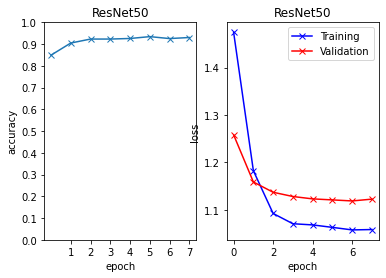

In [ ]:
plt.figure(figsize = (6,4))
plt.subplot(121)
plot_accuracies(history_res50)
plt.title('ResNet50')
plt.subplot(122)
plot_losses(history_res50)
plt.title('ResNet50')

### confusion Matrix

In [ ]:
nb_classes = 6

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_dl):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_res50(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)


from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import matplotlib.pyplot as plt

nb_classes = 6
label=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_dl):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_res50(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

tensor([[ 67.,   0.,   0.,   3.,   0.,   0.],
        [  0.,  97.,   5.,   0.,   1.,   0.],
        [  0.,   3.,  75.,   0.,   2.,   0.],
        [  1.,   0.,   1., 122.,   0.,   1.],
        [  0.,   3.,   0.,   0., 102.,   1.],
        [  0.,   0.,   0.,   1.,   5.,  16.]])
[[ 67   0   0   3   0   0]
 [  0  97   5   0   1   0]
 [  0   3  75   0   2   0]
 [  1   0   1 122   0   1]
 [  0   3   0   0 102   1]
 [  0   0   0   1   5  16]]


Confusion matrix, without normalization
[[ 67   0   0   3   0   0]
 [  0  97   5   0   1   0]
 [  0   3  75   0   2   0]
 [  1   0   1 122   0   1]
 [  0   3   0   0 102   1]
 [  0   0   0   1   5  16]]


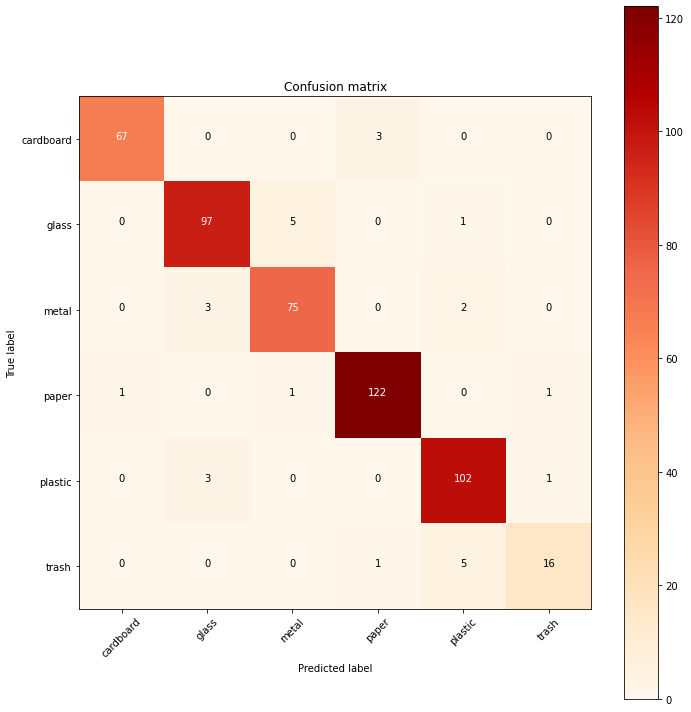

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.OrRd):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
# Confusion matrix_시각화
import itertools
plt.figure(figsize=(10,10))
plot_confusion_matrix(conf_mat, label)

## 틀린 이미지 확인

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
for i in range(len(test_ds)):
  img, label = test_ds[i]
  # plt.imshow(img.permute(1,2,0))
  if dataset.classes[label] != predict_image(img,model_res50):
    print(i,'번','Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_res50))
  else:
    pass     # 총 30개

2 번 Label: plastic , Predicted: metal
17 번 Label: plastic , Predicted: metal
38 번 Label: glass , Predicted: metal
63 번 Label: plastic , Predicted: glass
99 번 Label: metal , Predicted: plastic
117 번 Label: cardboard , Predicted: paper
137 번 Label: metal , Predicted: plastic
155 번 Label: plastic , Predicted: glass
171 번 Label: metal , Predicted: glass
173 번 Label: plastic , Predicted: paper
191 번 Label: paper , Predicted: trash
197 번 Label: plastic , Predicted: trash
209 번 Label: metal , Predicted: glass
213 번 Label: metal , Predicted: glass
216 번 Label: plastic , Predicted: glass
227 번 Label: plastic , Predicted: glass
250 번 Label: plastic , Predicted: cardboard
251 번 Label: plastic , Predicted: metal
255 번 Label: glass , Predicted: metal
294 번 Label: metal , Predicted: glass
297 번 Label: cardboard , Predicted: paper
318 번 Label: trash , Predicted: paper
324 번 Label: paper , Predicted: plastic
372 번 Label: glass , Predicted: plastic
375 번 Label: glass , Predicted: paper
389 번 Label: pla

## 이미지로 확인

Label: plastic , Predicted: metal


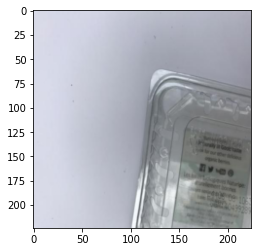

In [ ]:
img, label = test_ds[2]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_res50))

Label: plastic , Predicted: metal


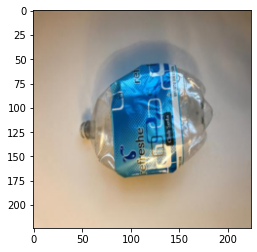

In [ ]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_res50))

Label: glass , Predicted: metal


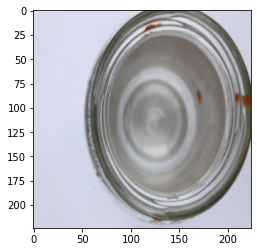

In [ ]:
img, label = test_ds[38]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_res50))

Label: plastic , Predicted: trash


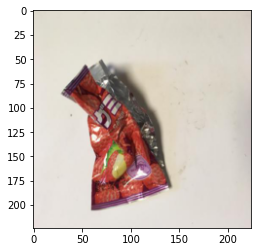

In [ ]:
img, label = test_ds[197]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_res50))

Label: plastic , Predicted: cardboard


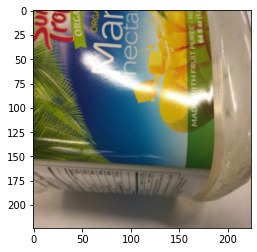

In [ ]:
img, label = test_ds[250]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_res50))

Label: glass , Predicted: paper


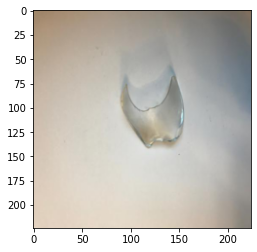

In [ ]:
img, label = test_ds[375]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_res50))

Label: paper , Predicted: trash


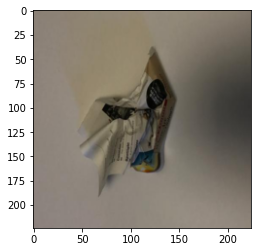

In [ ]:
img, label = test_ds[466]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model_res50))